In [1]:
import sys
import os
script_dir = os.getcwd() # coleata o diretorio do projeto atual
sys.path.append(script_dir)

Area de impoets

In [2]:
import cv2
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skimage.feature import local_binary_pattern, hog

In [3]:
def carregar_imagens_pasta(base_path, target_size=(224, 224)):
    imagens = []
    labels = []
    
    # Percorre cada classe (pastas de classe)
    for classe in os.listdir(base_path):
        classe_path = os.path.join(base_path, classe, 'images')  # Caminho da pasta images
        
        # Verifica se é uma pasta válida
        if os.path.isdir(classe_path):
            # Percorre cada imagem dentro da pasta de imagens
            for img_name in os.listdir(classe_path):
                img_path = os.path.join(classe_path, img_name)
                
                # Carrega a imagem usando cv2
                img = cv2.imread(img_path)
                
                # Verifica se a imagem foi carregada corretamente
                if img is not None:
                    # Redimensiona a imagem
                    img_resized = cv2.resize(img, target_size)
                    
                    # Normaliza a imagem (opcional: normalize entre [0, 1])
                    img_normalized = img_resized / 255.0
                    
                    # Adiciona a imagem e o label (nome da classe) à lista
                    imagens.append(img_normalized)
                    labels.append(classe)
    
    return np.array(imagens), np.array(labels)


In [4]:
def create_MLP_model(input_dim, output_dim, dense_layers):
    model = models.Sequential()
    
    # Redimensionar os dados de entrada
    model.add(layers.Reshape((input_dim,), input_shape=(input_dim, 1)))
    
    model.add(layers.Dense(dense_layers[0], activation='relu'))

    for neurons in dense_layers[1:]:
        model.add(layers.Dense(neurons, activation='relu'))

    model.add(layers.Dense(output_dim, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def create_CNN_model(input, num_classes):
    model = Sequential([
    # Camada convolucional
    Conv2D(32, (3, 3), activation='relu', input_shape=input),
    MaxPooling2D((2, 2)),
    
    # Camada convolucional
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Camada convolucional
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Camada de flattening
    Flatten(),
    
    # Camada densa
    Dense(128, activation='relu'),
    
    # Camada de saída com softmax
    Dense(num_classes, activation='softmax')])

    # 3. Compilar o Modelo
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    return model


In [5]:
def coletor_Hu(imagem):
    imagem = (imagem * 255).astype(np.uint8)
    imagem_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(imagem_cinza)
    saida = cv2.HuMoments(moments).flatten()
    return saida

def coletor_LBP(imagem, raio=1, pontos=8, metodo='uniform'):

    raio = 1  
    pontos = 8 * raio  

    imagem = (imagem * 255).astype(np.uint8)
    imagem_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    
    lbp = local_binary_pattern(imagem_cinza, pontos, raio, metodo).flatten()
    
    return lbp

def coletor_HOG(imagem, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientacoes=9):
    imagem = (imagem * 255).astype(np.uint8)
    imagem_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    
    hog_features, hog_image = hog(imagem_cinza, orientations=orientacoes, 
                                  pixels_per_cell=pixels_per_cell, 
                                  cells_per_block=cells_per_block, 
                                  block_norm='L2-Hys', visualize=True)
    
    return hog_features

def concatenar_inputs(Hu, LBP):
    return np.concatenate((Hu, LBP))

def cridaor_input_unico(imagem):
    hu_image = coletor_Hu(imagem)  # Extrair momentos de Hu
    LBP = coletor_LBP(imagem)  # Extrair LBP
    #HOG = coletor_HOG(imagem)  # Extrair HOG
    
    #saida = concatenar_inputs(np.concatenate((hu_image, LBP)), HOG)
    saida = concatenar_inputs(hu_image, LBP)
    return saida

def produtor_MLP_Base(Base_criator):
    saida_base = []
    for x in Base_criator:
        saida_base.append(cridaor_input_unico(x))
    return saida_base


In [6]:
# Função para salvar o histórico
def salvar_historico(history, nome_modelo, caminho='historicos'):
    os.makedirs(caminho, exist_ok=True)
    arquivo = os.path.join(caminho, f"{nome_modelo}_historico.npy")
    np.save(arquivo, history.history)

# Função para gerar e salvar a matriz de confusão
def salvar_matriz_confusao(y_true, y_pred, classes, nome_modelo, caminho='historicos'):
    os.makedirs(caminho, exist_ok=True)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)

    plt.title(f'Matriz de Confusão - {nome_modelo}')
    arquivo = os.path.join(caminho, f"{nome_modelo}_matriz_confusao.png")
    plt.savefig(arquivo)
    plt.close()

In [7]:
def mostrar_exemplos(imagens, labels, classes, num_exemplos=3):
    # Configura a visualização
    fig, axes = plt.subplots(len(classes), num_exemplos, figsize=(15, 5 * len(classes)))
    
    for i, classe in enumerate(classes):
        # Filtra imagens da classe atual
        indices = np.where(labels == classe)[0]
        exemplos = np.random.choice(indices, num_exemplos, replace=False)
        
        for j, idx in enumerate(exemplos):
            img = imagens[idx]
            ax = axes[i, j]
            ax.imshow(img)
            ax.axis('off')
        
        # Adiciona o título no centro da coluna da classe
        ax_title = axes[i, num_exemplos // 2]
        ax_title.set_title(f'{classe}', fontsize=12, fontweight='bold', ha='center', va='center')
        ax_title.axis('off')
    
    plt.tight_layout()
    plt.show()

In [8]:
# Carregar imagens de treino
train_path = 'Data/Train'
X_train, y_train = carregar_imagens_pasta(train_path)

# Carregar imagens de validação
val_path = 'Data/Val'
X_val, y_val = carregar_imagens_pasta(val_path)


In [9]:
# Visualizar a quantidade de imagens carregadas
print(f"Total de imagens de treino: {len(X_train)}")
print(f"Total de imagens de validação: {len(X_val)}")
print(f"Total de classes: {set(y_val)}")

Total de imagens de treino: 4737
Total de imagens de validação: 512
Total de classes: {'Pituitary', 'Glioma', 'No Tumor', 'Meningioma'}


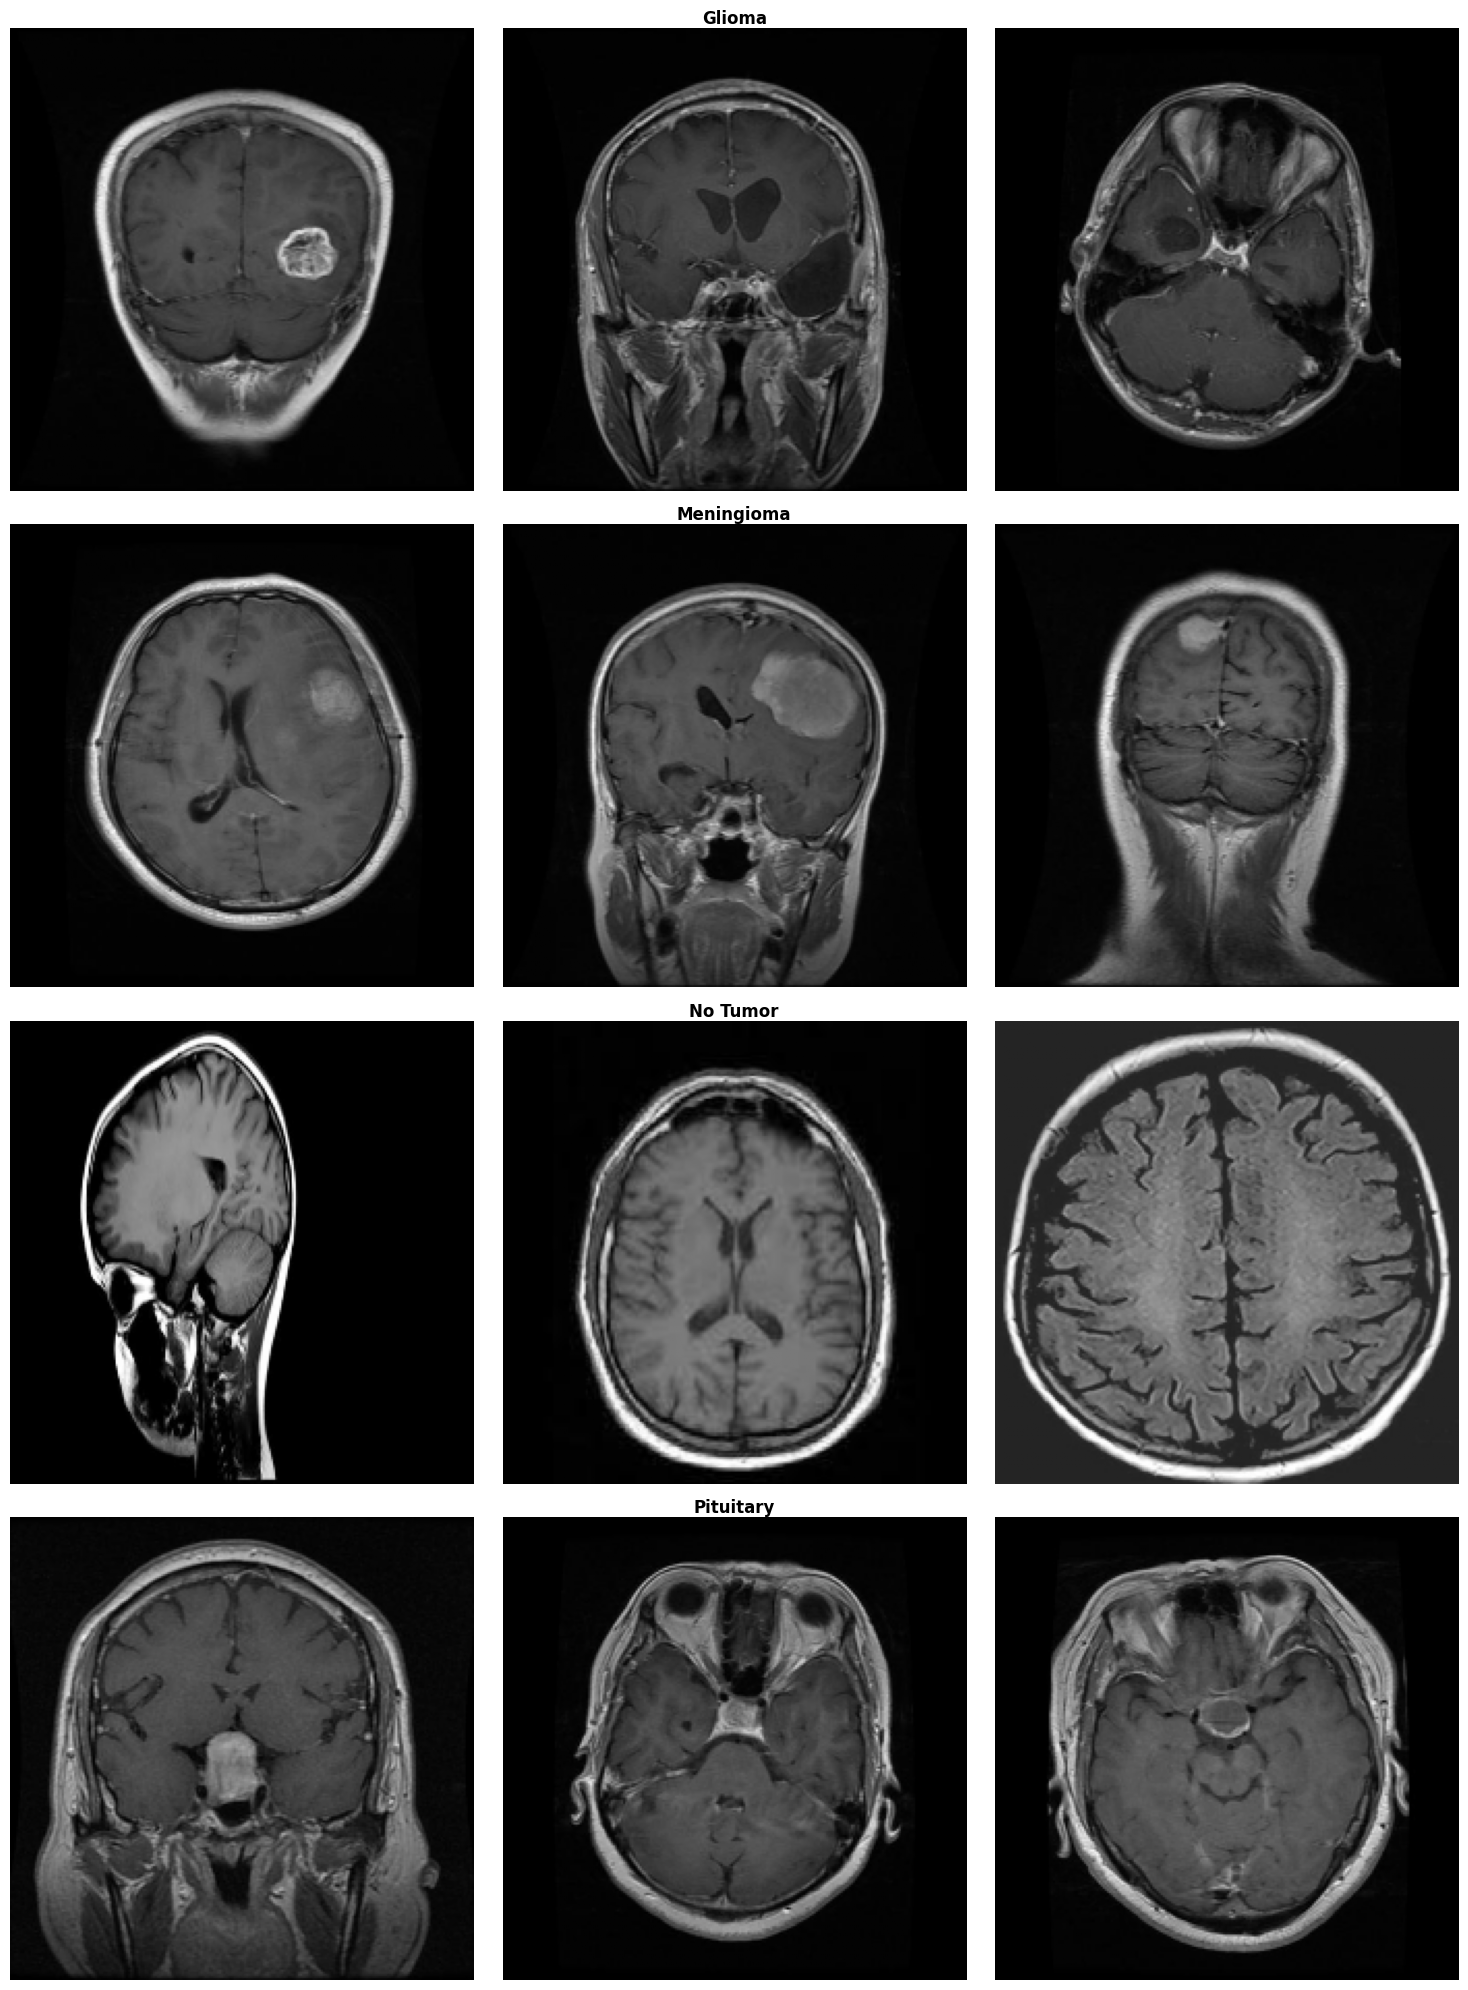

In [10]:
# Supondo que você já carregou as imagens e rótulos
# Classes devem ser as labels únicas presentes no seu dataset
classes = np.unique(y_train)
mostrar_exemplos(X_train, y_train, classes)


In [11]:
X_MLP_base_train = np.array(produtor_MLP_Base(X_train))
X_MLP_base_val = np.array(produtor_MLP_Base(X_val))

In [12]:
# Codificar os rótulos de classe em números
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [13]:
# One-hot encoding dos rótulos
num_classes = len(np.unique(y_train_encoded))
y_train_one_hot = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes=num_classes)

In [19]:
input_shape = X_train[0].shape
saida = num_classes

model_cnn = create_CNN_model(input_shape, saida)

c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [14]:
input = len(X_MLP_base_train[0])
saida = num_classes
dense_layers = [64, 32, 64]

model_mlp = create_MLP_model(input, saida, dense_layers)

c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
history_mlp = model_mlp.fit(
    X_MLP_base_train, y_train_one_hot,
    epochs=10,  # Número de épocas, ajuste conforme necessário
    batch_size=32,
    validation_data=(X_MLP_base_val, y_val_one_hot)
)

val_loss, val_accuracy = model_mlp.evaluate(X_MLP_base_val, y_val_one_hot)
print(f'Perda de Validação: {val_loss}')
print(f'Precisão de Validação: {val_accuracy}')

# Salvar histórico do MLP
salvar_historico(history_mlp, 'mlp')

Epoch 1/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9988 - loss: 0.0153 - val_accuracy: 0.8691 - val_loss: 0.4053
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 0.8613 - val_loss: 0.4142
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 1.0000 - loss: 0.0078 - val_accuracy: 0.8730 - val_loss: 0.4058
Epoch 4/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.8652 - val_loss: 0.4181
Epoch 5/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 0.8691 - val_loss: 0.3962
Epoch 6/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 0.8594 - val_loss: 0.4371
Epoch 7/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.8730 - val_loss: 0.4299
Epoch 8/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accu

In [18]:
# Previsões para matriz de confusão da CNN
y_pred_MLP = np.argmax(model_mlp.predict(X_MLP_base_val), axis=1)
y_true_MLP = np.argmax(y_val_one_hot, axis=1)
classes_cnn = ['No Tumor', 'Pituitary', 'Glioma', 'Meningioma']
salvar_matriz_confusao(y_true_MLP, y_pred_MLP, classes_cnn, 'mlp')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [20]:
history_cnn = model_cnn.fit(
    X_train, y_train_one_hot,
    epochs=10,  # Número de épocas, ajuste conforme necessário
    batch_size=32,
    validation_data=(X_val, y_val_one_hot)
)

val_loss, val_accuracy = model_cnn.evaluate(X_val, y_val_one_hot)
print(f'Perda de Validação: {val_loss}')
print(f'Precisão de Validação: {val_accuracy}')

# Salvar histórico da CNN
salvar_historico(history_cnn, 'cnn')


Epoch 1/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 103s 674ms/step - accuracy: 0.6016 - loss: 1.0742 - val_accuracy: 0.7383 - val_loss: 0.5768
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 101s 680ms/step - accuracy: 0.8541 - loss: 0.3779 - val_accuracy: 0.7695 - val_loss: 0.5751
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 90s 603ms/step - accuracy: 0.9289 - loss: 0.1901 - val_accuracy: 0.8730 - val_loss: 0.4346
Epoch 4/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 88s 589ms/step - accuracy: 0.9723 - loss: 0.1014 - val_accuracy: 0.9219 - val_loss: 0.2772
Epoch 5/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 88s 588ms/step - accuracy: 0.9883 - loss: 0.0356 - val_accuracy: 0.9219 - val_loss: 0.2990
Epoch 6/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 89s 597ms/step - accuracy: 0.9906 - loss: 0.0315 - val_accuracy: 0.9258 - val_loss: 0.3539
Epoch 7/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 84s 562ms/step - accuracy: 0.9905 - loss: 0.0285 - val_accuracy: 0.9531 - val_loss: 0.2195
Epoch 8/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 78s 521ms/step - accuracy: 0.9911 - loss:

In [23]:
# Previsões para matriz de confusão da CNN
y_pred_cnn = np.argmax(model_cnn.predict(X_val), axis=1)
y_true_cnn = np.argmax(y_val_one_hot, axis=1)
classes_cnn = ['No Tumor', 'Pituitary', 'Glioma', 'Meningioma']
salvar_matriz_confusao(y_true_cnn, y_pred_cnn, classes_cnn, 'cnn')

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step


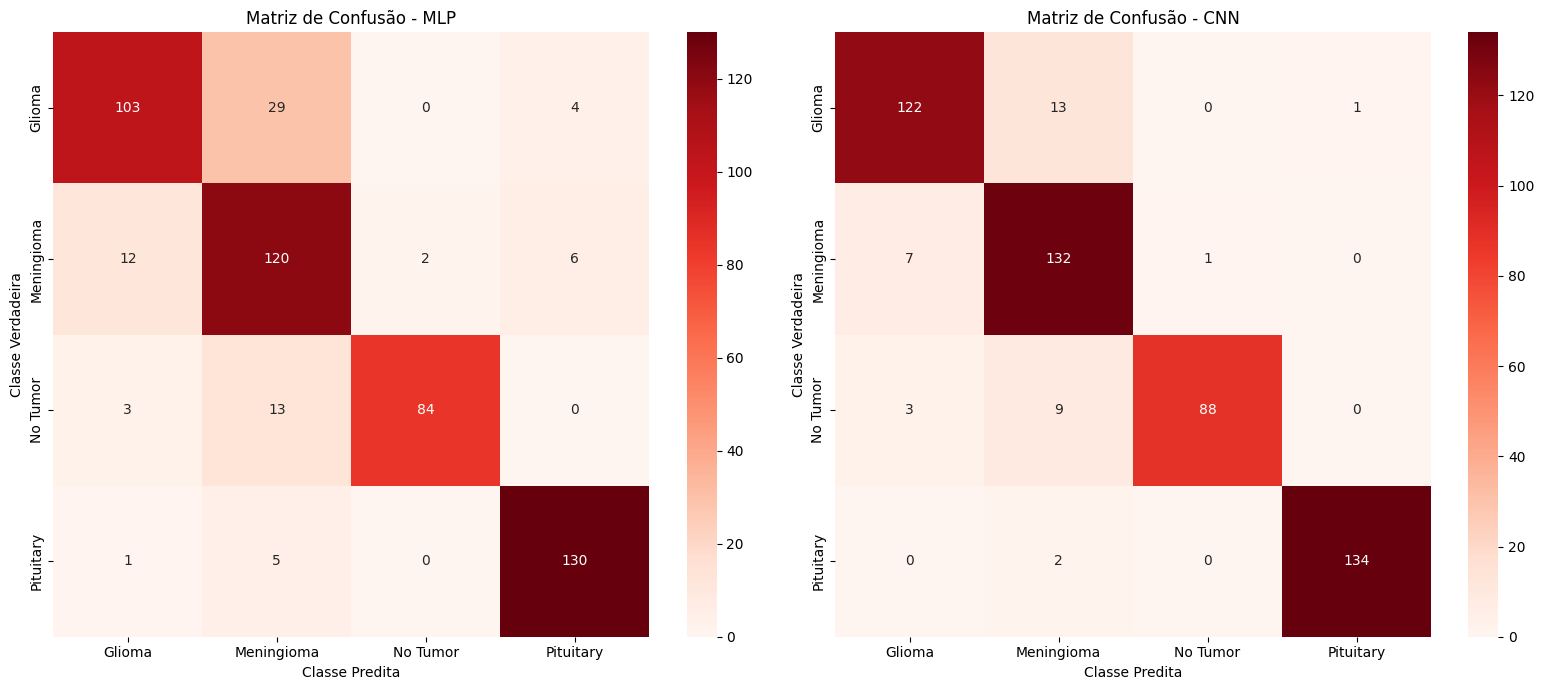

In [24]:
y_pred_mlp = model_mlp.predict(X_MLP_base_val)
y_pred_classes_mlp = np.argmax(y_pred_mlp, axis=1)

y_pred_cnn = model_cnn.predict(X_val)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)

y_true = np.argmax(y_val_one_hot, axis=1)

conf_matrix_mlp = confusion_matrix(y_true, y_pred_classes_mlp)
conf_matrix_cnn = confusion_matrix(y_true, y_pred_classes_cnn)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Reds', ax=axes[0],
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
axes[0].set_title('Matriz de Confusão - MLP')
axes[0].set_xlabel('Classe Predita')
axes[0].set_ylabel('Classe Verdadeira')

sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
axes[1].set_title('Matriz de Confusão - CNN')
axes[1].set_xlabel('Classe Predita')
axes[1].set_ylabel('Classe Verdadeira')

plt.tight_layout()
plt.show()

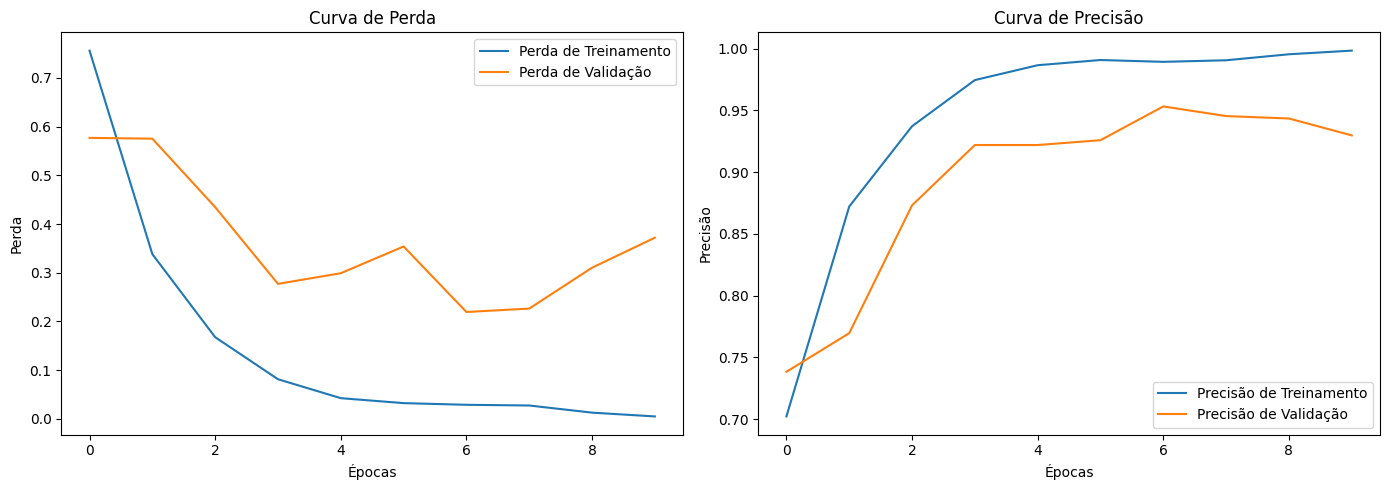

In [25]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Perda de Treinamento')
plt.plot(history_cnn.history['val_loss'], label='Perda de Validação')
plt.title('Curva de Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Precisão de Treinamento')
plt.plot(history_cnn.history['val_accuracy'], label='Precisão de Validação')
plt.title('Curva de Precisão')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()

plt.tight_layout()
plt.show()


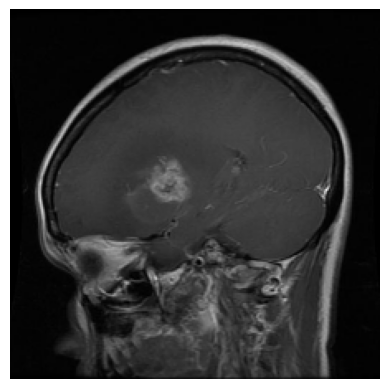

In [26]:
Imagem_pika = X_train[5]
Imagem_pika = (Imagem_pika * 255).astype(np.uint8)

plt.imshow(Imagem_pika)
plt.axis('off')  # Oculta os eixos
plt.show()

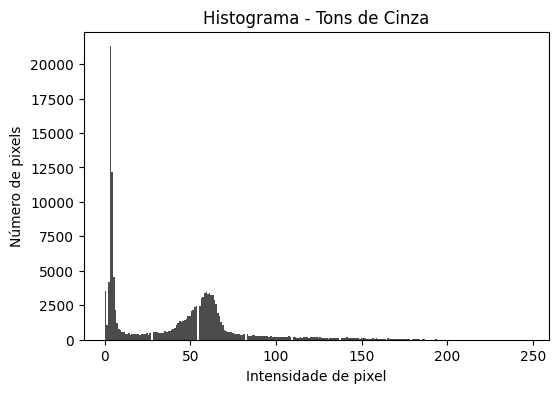

In [27]:
plt.figure(figsize=(6, 4))
plt.hist(Imagem_pika.ravel(), bins=256, color='black', alpha=0.7)
plt.title('Histograma - Tons de Cinza')
plt.xlabel('Intensidade de pixel')
plt.ylabel('Número de pixels')
plt.show()

In [28]:
def equalizar_histograma_com_ajuste_brilho(imagem_usada):
    # Certifique-se de que a imagem está no formato correto
    if imagem_usada.dtype != np.uint8:
        imagem_usada = np.uint8(imagem_usada)
    
    imagem_usada = cv2.cvtColor(imagem_usada, cv2.COLOR_BGR2GRAY)
    imagem_equalizada = cv2.equalizeHist(imagem_usada)
    imagem_brilho = cv2.convertScaleAbs(imagem_equalizada, alpha=0.5, beta=0)
    return imagem_brilho

def limiarizacao_binaria(imagem_usada):
    # Certifique-se de que a imagem está no formato correto
    if imagem_usada.dtype != np.uint8:
        imagem_usada = np.uint8(imagem_usada)
    
    limiar = 90
    imagem_usada = cv2.cvtColor(imagem_usada, cv2.COLOR_BGR2GRAY)
    _, binary_img = cv2.threshold(imagem_usada, limiar, 255, cv2.THRESH_BINARY)
    return binary_img

def limiarizacao_binaria_com_gaussian_blur(imagem_usada):
    # Certifique-se de que a imagem está no formato correto
    if imagem_usada.dtype != np.uint8:
        imagem_usada = np.uint8(imagem_usada)
    
    limiar = 90
    imagem_usada = cv2.cvtColor(imagem_usada, cv2.COLOR_BGR2GRAY)
    blurred_img = cv2.GaussianBlur(imagem_usada, (5, 5), 0)
    _, binary_img = cv2.threshold(blurred_img, limiar, 255, cv2.THRESH_BINARY)
    return binary_img

def equalizacao_histograma_com_limiarizacao_binaria(imagem_usada):
    # Certifique-se de que a imagem está no formato correto
    if imagem_usada.dtype != np.uint8:
        imagem_usada = np.uint8(imagem_usada)
    
    limiar = 220
    imagem_usada = cv2.cvtColor(imagem_usada, cv2.COLOR_BGR2GRAY)
    imagem_equalizada = cv2.equalizeHist(imagem_usada)
    _, binary_img = cv2.threshold(imagem_equalizada, limiar, 255, cv2.THRESH_BINARY)
    return binary_img

def limiarizacao_gaussian_com_componentes_conectados(imagem_usada):
    # Certifique-se de que a imagem está no formato correto
    if imagem_usada.dtype != np.uint8:
        imagem_usada = np.uint8(imagem_usada)
    
    limiar = 100
    imagem_usada = cv2.cvtColor(imagem_usada, cv2.COLOR_BGR2GRAY)
    blurred_img = cv2.GaussianBlur(imagem_usada, (5, 5), 0)
    _, binary_img = cv2.threshold(blurred_img, limiar, 255, cv2.THRESH_BINARY)
    binary_img = binary_img.astype(np.uint8)

    _, labels_im = cv2.connectedComponents(binary_img)

    label_hue = np.uint8(179 * labels_im / np.max(labels_im))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0  # Definir fundo como preto

    return labeled_img

def filtro_mediana_com_normalizacao_e_componentes_conectados(imagem_usada):
    # Certifique-se de que a imagem está no formato correto
    if imagem_usada.dtype != np.uint8:
        imagem_usada = np.uint8(imagem_usada)
    
    limiar = 120
    imagem_usada = cv2.cvtColor(imagem_usada, cv2.COLOR_BGR2GRAY)
    imagem_mediana = cv2.medianBlur(imagem_usada, 5)
    imagem_normalizada = cv2.normalize(imagem_mediana, None, 0, 255, cv2.NORM_MINMAX)
    _, binary_img = cv2.threshold(imagem_normalizada, limiar, 255, cv2.THRESH_BINARY)

    _, labels_im = cv2.connectedComponents(binary_img)

    label_hue = np.uint8(179 * labels_im / np.max(labels_im))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0  # Definir fundo como preto

    return labeled_img

def limiarizacao_gaussian_com_laplaciano_e_componentes_conectados(imagem_usada):
    # Certifique-se de que a imagem está no formato correto
    if imagem_usada.dtype != np.uint8:
        imagem_usada = np.uint8(imagem_usada)
    
    limiar = 100
    imagem_usada = cv2.cvtColor(imagem_usada, cv2.COLOR_BGR2GRAY)
    blurred_img = cv2.GaussianBlur(imagem_usada, (5, 5), 0)
    _, binary_img = cv2.threshold(blurred_img, limiar, 255, cv2.THRESH_BINARY)
    binary_img = binary_img.astype(np.uint8)

    _, labels_im = cv2.connectedComponents(binary_img)

    # Normalizar os rótulos para exibir como imagem (escala de cores)
    label_hue = np.uint8(179 * labels_im / np.max(labels_im))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converter para BGR e aplicar a máscara binária
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0  # Definir fundo como preto

    laplacian = cv2.Laplacian(labeled_img, cv2.CV_8U)

    return laplacian


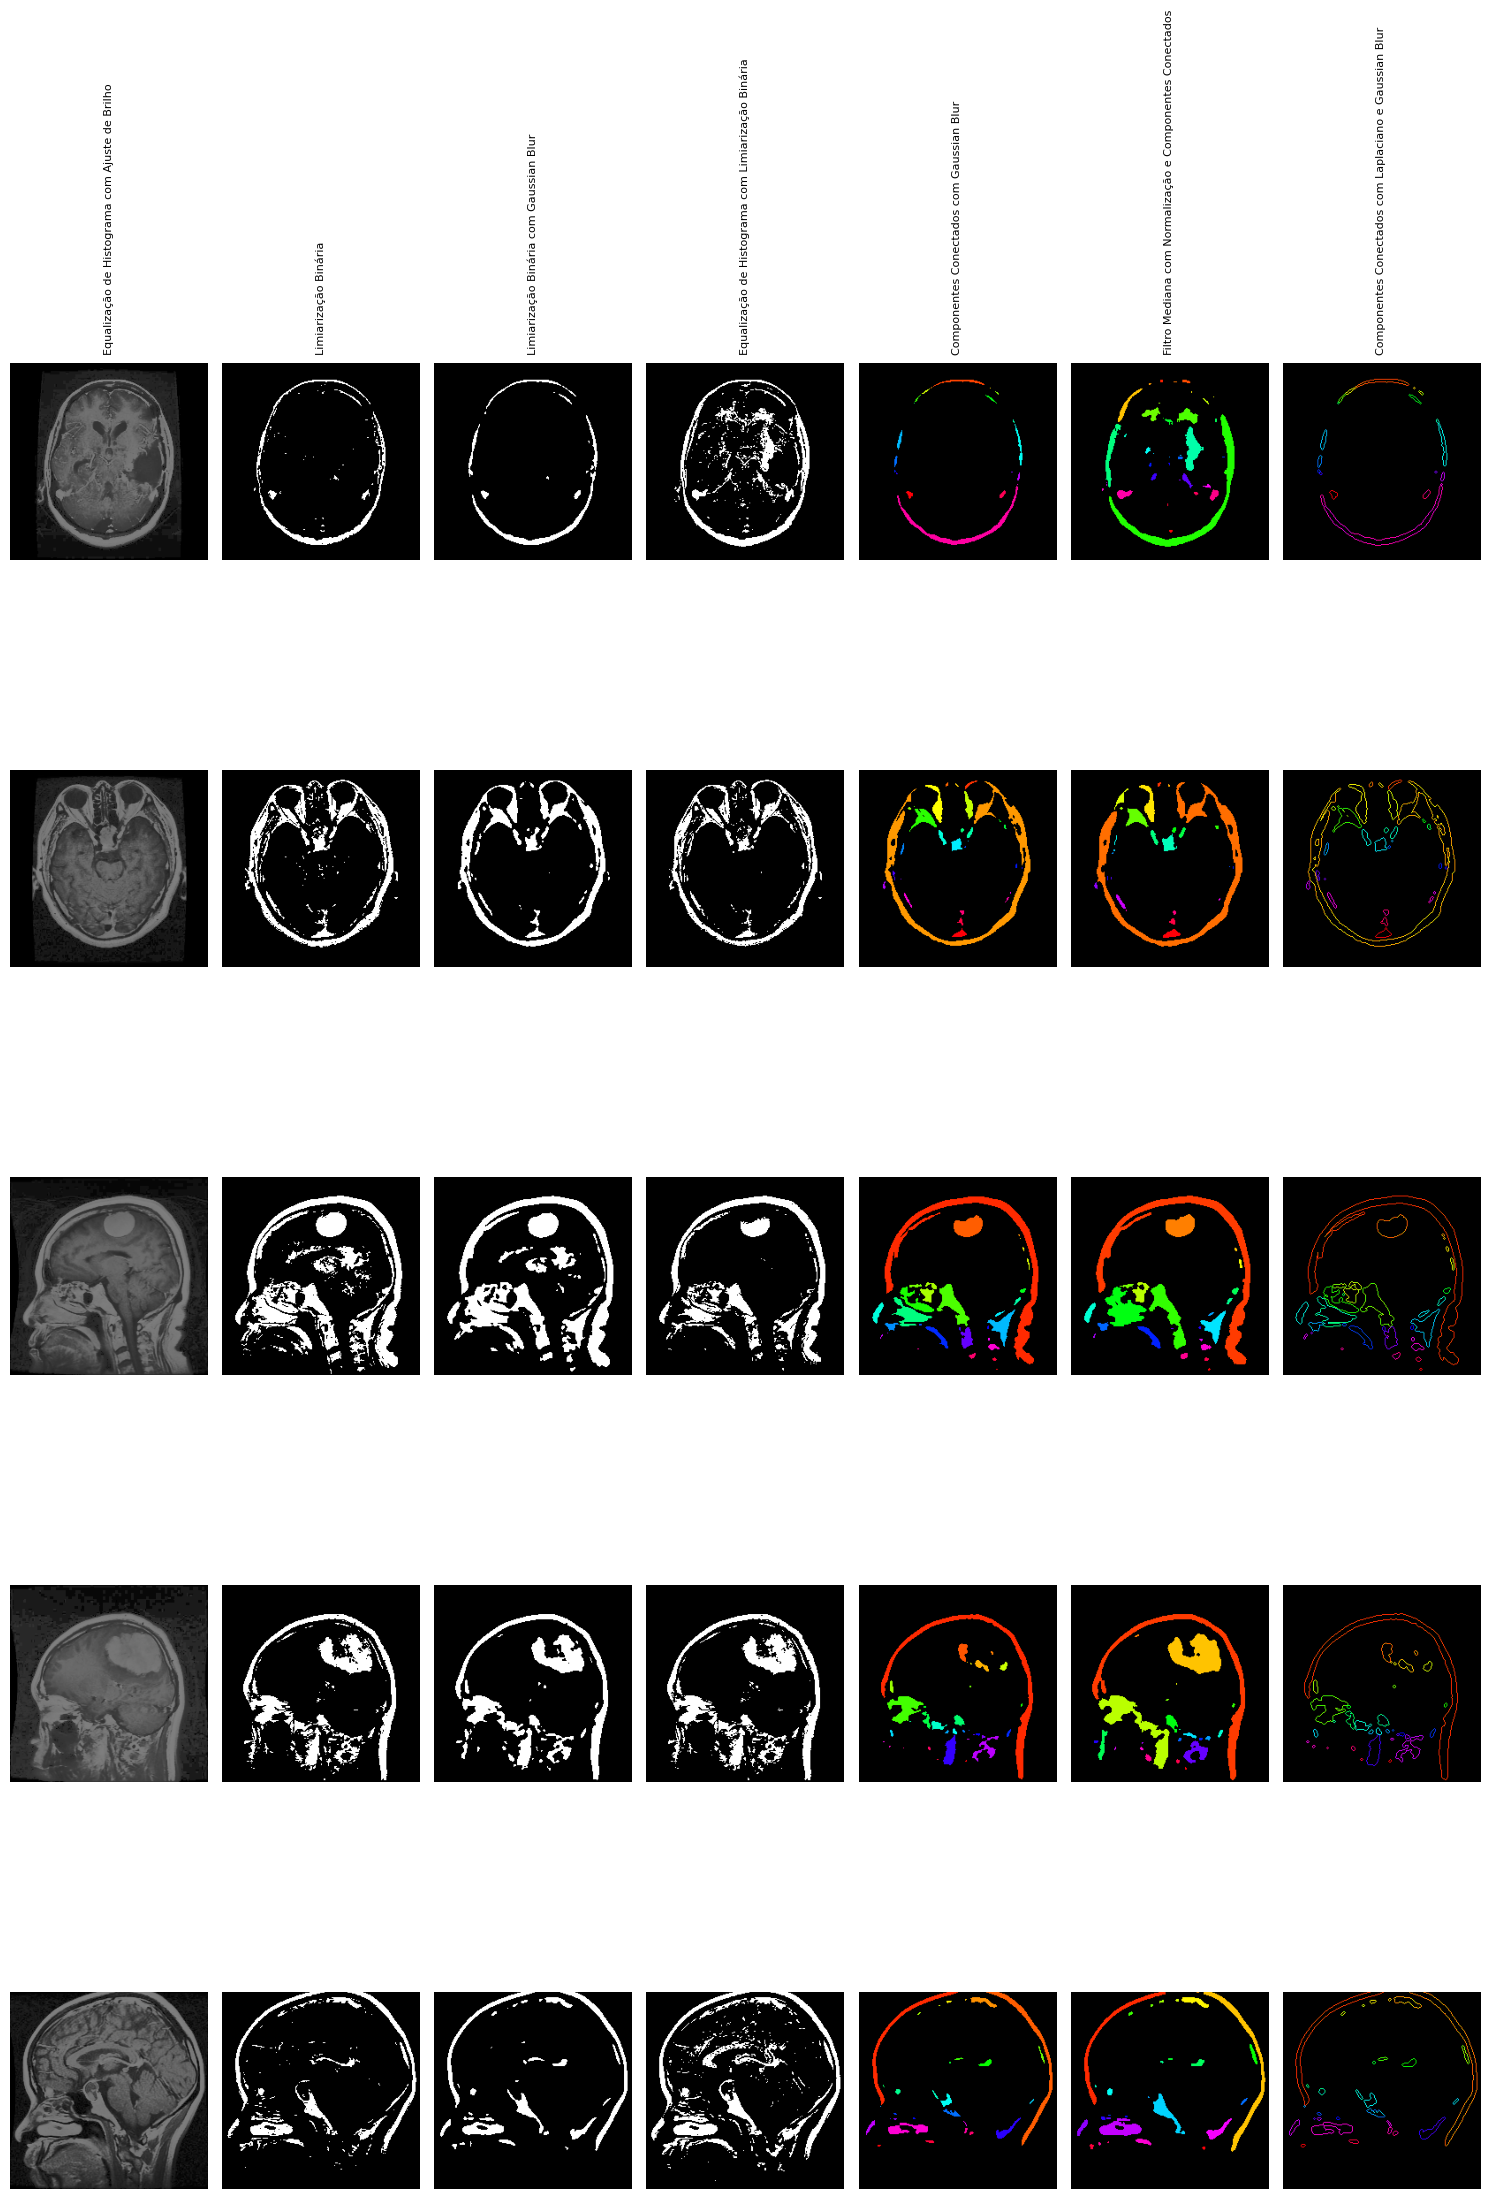

In [29]:
# Selecionar 5 índices aleatórios
np.random.seed(2020)  # Para reprodutibilidade
indices_aleatorios = np.random.choice(len(X_train), 5, replace=False)

# Definir os métodos de pré-processamento
metodos_pre_processamento = {
    'Equalização de Histograma com Ajuste de Brilho': equalizar_histograma_com_ajuste_brilho,
    'Limiarização Binária': limiarizacao_binaria,
    'Limiarização Binária com Gaussian Blur': limiarizacao_binaria_com_gaussian_blur,
    'Equalização de Histograma com Limiarização Binária': equalizacao_histograma_com_limiarizacao_binaria,
    'Componentes Conectados com Gaussian Blur': limiarizacao_gaussian_com_componentes_conectados,
    'Filtro Mediana com Normalização e Componentes Conectados': filtro_mediana_com_normalizacao_e_componentes_conectados,
    'Componentes Conectados com Laplaciano e Gaussian Blur': limiarizacao_gaussian_com_laplaciano_e_componentes_conectados,
}

# Número de métodos de pré-processamento
num_metodos = len(metodos_pre_processamento)
num_exemplos = len(indices_aleatorios)

# Criar subplots: uma linha para cada imagem e uma coluna para cada método
fig, axes = plt.subplots(num_exemplos, num_metodos, figsize=(15, 5*num_exemplos))

# Iterar sobre os exemplos aleatórios e métodos de pré-processamento
for i, idx in enumerate(indices_aleatorios):
    imagem_exemplo = X_train[idx]
    imagem_exemplo = (imagem_exemplo * 255).astype(np.uint8)  # Converter para imagem 8-bit

    for j, (nome_metodo, metodo) in enumerate(metodos_pre_processamento.items()):
        imagem_processada = metodo(imagem_exemplo)
        ax = axes[i, j]
        ax.imshow(cv2.cvtColor(imagem_processada, cv2.COLOR_BGR2RGB))
        if i == 0:
            ax.set_title(nome_metodo, fontsize=8, rotation=90, verticalalignment='bottom')  # Título na primeira linha
        if j == 0:
            ax.set_ylabel(f'Imagem {i+1}', fontsize=8)  # Rótulo das imagens na primeira coluna
        ax.axis('off')  # Desativar eixos

plt.tight_layout()
plt.show()


In [31]:
imagem = []
for nome, conteudo in metodos_pre_processamento.items():
    
    # Para o modelo CNN
    X_MLP_base_train = []
    for image in X_train:
        imagem_exemplo = (image * 255).astype(np.uint8)  # Converter para imagem 8-bit
        imagem_final = conteudo(imagem_exemplo)
        if len(imagem_final.shape) == 2:
            imagem_final = cv2.cvtColor(imagem_final, cv2.COLOR_GRAY2RGB)
        X_MLP_base_train.append(imagem_final)
    X_MLP_base_train = np.array(X_MLP_base_train)
    imagem.append(X_MLP_base_train[0])

In [33]:
imagem_aaa = np.array(produtor_MLP_Base(imagem))

In [38]:
X_MLP_base_train = np.array(produtor_MLP_Base(X_MLP_base_train))

In [35]:
imagem_aaa[0].shape

(50183,)

In [39]:
input = len(X_MLP_base_train[0])
saida = num_classes
dense_layers = [64, 32, 64]

model_mlp = create_MLP_model(input, saida, dense_layers)

c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


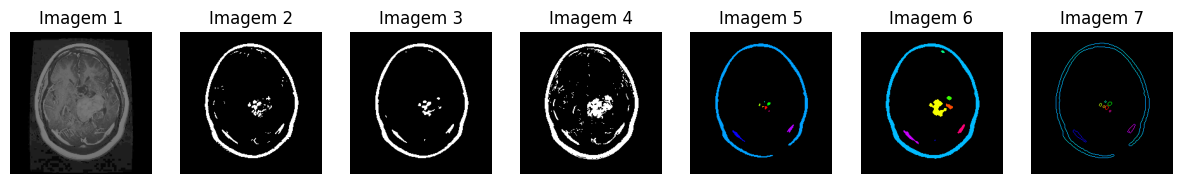

In [32]:
# Função para plotar as imagens armazenadas na lista 'imagem'
def plotar_imagens(imagens):
    plt.figure(figsize=(15, 10))  # Definir o tamanho da figura
    num_imagens = len(imagens)
    
    for i, img in enumerate(imagens):
        plt.subplot(1, num_imagens, i + 1)  # Criar subplots em uma única linha
        plt.imshow(img)
        plt.axis('off')  # Remover os eixos para melhorar a visualização
        plt.title(f'Imagem {i+1}')  # Título para cada subplot
    
    plt.show()

# Chamar a função para plotar as imagens
plotar_imagens(imagem)

In [41]:
for nome, conteudo in metodos_pre_processamento.items():
    # Para o modelo CNN
    X_MLP_base_train = []
    for image in X_train:
        imagem_exemplo = (image * 255).astype(np.uint8)  # Converter para imagem 8-bit
        imagem_final = conteudo(imagem_exemplo)
        if len(imagem_final.shape) == 2:
            imagem_final = cv2.cvtColor(imagem_final, cv2.COLOR_GRAY2RGB)
        X_MLP_base_train.append(imagem_final)
    X_MLP_base_train = np.array(X_MLP_base_train)

    X_MLP_base_val = []
    for image in X_val:
        imagem_exemplo = (image * 255).astype(np.uint8)  # Converter para imagem 8-bit
        imagem_final = conteudo(imagem_exemplo)
        if len(imagem_final.shape) == 2:
            imagem_final = cv2.cvtColor(imagem_final, cv2.COLOR_GRAY2RGB)
        X_MLP_base_val.append(imagem_final)
    X_MLP_base_val = np.array(X_MLP_base_val)

    '''
    input_shape = X_MLP_base_train[0].shape
    saida = num_classes

    model_cnn = create_CNN_model(input_shape, saida)

    history_cnn = model_cnn.fit(
        X_MLP_base_train, y_train_one_hot,
        epochs=10,
        batch_size=32,
        validation_data=(X_MLP_base_val, y_val_one_hot)
    )

    # Avaliação do modelo CNN
    val_loss, val_accuracy = model_cnn.evaluate(X_MLP_base_val, y_val_one_hot)
    print(f"Modelo CNN: {nome}")
    print(f'Perda de Validação: {val_loss}')
    print(f'Precisão de Validação: {val_accuracy}')
    print("-" * 30)

    # Salvando o histórico da CNN
    salvar_historico(history_cnn, f"{nome}_CNN")

    # Gerar e salvar matriz de confusão da CNN
    y_pred_cnn = np.argmax(model_cnn.predict(X_MLP_base_val), axis=1)
    y_true_val = np.argmax(y_val_one_hot, axis=1)
    salvar_matriz_confusao(y_true_val, y_pred_cnn, classes=['No Tumor', 'Pituitary', 'Glioma', 'Meningioma'], nome_modelo=f"{nome}_CNN")
    '''

    # Para o modelo MLP
    X_MLP_base_train = np.array(produtor_MLP_Base(X_MLP_base_train))
    X_MLP_base_val = np.array(produtor_MLP_Base(X_MLP_base_val))

    input = len(X_MLP_base_train[0])
    saida = num_classes
    dense_layers = [64, 32, 64]

    model_mlp = create_MLP_model(input, saida, dense_layers)

    history_mlp = model_mlp.fit(
        X_MLP_base_train, y_train_one_hot,
        epochs=30,
        batch_size=32,
        validation_data=(X_MLP_base_val, y_val_one_hot)
    )

    # Avaliação do modelo MLP
    val_loss, val_accuracy = model_mlp.evaluate(X_MLP_base_val, y_val_one_hot)
    print(f"Modelo MLP: {nome}")
    print(f'Perda de Validação: {val_loss}')
    print(f'Precisão de Validação: {val_accuracy}')
    print("-" * 30)

    # Salvando o histórico da MLP
    salvar_historico(history_mlp, f"{nome}_MLP")

    # Gerar e salvar matriz de confusão da MLP
    y_pred_mlp = np.argmax(model_mlp.predict(X_MLP_base_val), axis=1)
    y_true_val = np.argmax(y_val_one_hot, axis=1)
    salvar_matriz_confusao(y_true_val, y_pred_mlp, classes=['No Tumor', 'Pituitary', 'Glioma', 'Meningioma'], nome_modelo=f"{nome}_MLP")

Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.3227 - loss: 18.6195 - val_accuracy: 0.2734 - val_loss: 8.5256
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5137 - loss: 2.8445 - val_accuracy: 0.6484 - val_loss: 0.9757
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6749 - loss: 0.7891 - val_accuracy: 0.2969 - val_loss: 4.4253
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6440 - loss: 1.3871 - val_accuracy: 0.7617 - val_loss: 0.6294
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8130 - loss: 0.5387 - val_accuracy: 0.5781 - val_loss: 1.0989
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7581 - loss: 0.6244 - val_accuracy: 0.7402 - val_loss: 0.6984
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8912 - loss: 0.2942 - val_accuracy: 0.8105 - val_loss: 0.5202
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9403 - loss: 0.1948 - val_acc

c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.2602 - loss: 39.1067 - val_accuracy: 0.2656 - val_loss: 16.8071
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2656 - loss: 13.5742 - val_accuracy: 0.3379 - val_loss: 4.9531
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.3060 - loss: 5.7842 - val_accuracy: 0.2656 - val_loss: 3.4256
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.3481 - loss: 1.8224 - val_accuracy: 0.2656 - val_loss: 3.4374
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.3292 - loss: 2.3298 - val_accuracy: 0.2656 - val_loss: 1.8863
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.3629 - loss: 1.6613 - val_accuracy: 0.2656 - val_loss: 3.2139
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.3815 - loss: 1.6109 - val_accuracy: 0.2734 - val_loss: 2.7644
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.4140 - loss: 1.4888 - val_a

c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.2672 - loss: 48.3802 - val_accuracy: 0.1953 - val_loss: 13.8300
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.2693 - loss: 19.7218 - val_accuracy: 0.1973 - val_loss: 8.8951
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2701 - loss: 5.5036 - val_accuracy: 0.2695 - val_loss: 3.5067
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.3118 - loss: 1.7783 - val_accuracy: 0.2773 - val_loss: 2.1510
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.3368 - loss: 1.6975 - val_accuracy: 0.2695 - val_loss: 5.6858
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.3548 - loss: 2.5623 - val_accuracy: 0.2695 - val_loss: 3.5031
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.2998 - loss: 3.6711 - val_accuracy: 0.2676 - val_loss: 7.7541
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2647 - loss: 9.3125 - val_a

c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.2720 - loss: 26.5549 - val_accuracy: 0.2656 - val_loss: 9.4653
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.2966 - loss: 3.0208 - val_accuracy: 0.2656 - val_loss: 2.0209
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.2848 - loss: 1.7357 - val_accuracy: 0.1816 - val_loss: 2.4636
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.2823 - loss: 2.4033 - val_accuracy: 0.2578 - val_loss: 3.2855
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.3059 - loss: 1.7983 - val_accuracy: 0.2656 - val_loss: 1.6027
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.3105 - loss: 1.3597 - val_accuracy: 0.2656 - val_loss: 1.4075
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2826 - loss: 1.3600 - val_accuracy: 0.2734 - val_loss: 1.3789
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.2953 - loss: 1.3612 - val_acc

c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.2757 - loss: 32.8372 - val_accuracy: 0.2656 - val_loss: 30.9651
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.2641 - loss: 8.7508 - val_accuracy: 0.2656 - val_loss: 3.3923
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.3103 - loss: 1.7801 - val_accuracy: 0.2656 - val_loss: 1.3848
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.2864 - loss: 1.3559 - val_accuracy: 0.2734 - val_loss: 1.3899
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.3026 - loss: 1.3470 - val_accuracy: 0.2734 - val_loss: 1.3870
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.2982 - loss: 1.3541 - val_accuracy: 0.2734 - val_loss: 1.3877
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.3006 - loss: 1.3487 - val_accuracy: 0.2734 - val_loss: 1.3892
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.3046 - loss: 1.3564 - val_ac

c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.2686 - loss: 26.4793 - val_accuracy: 0.2656 - val_loss: 11.1764
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.2737 - loss: 4.8523 - val_accuracy: 0.2734 - val_loss: 1.5599
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2911 - loss: 1.4728 - val_accuracy: 0.2656 - val_loss: 1.3994
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.3143 - loss: 1.3604 - val_accuracy: 0.2656 - val_loss: 1.3897
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2974 - loss: 1.3675 - val_accuracy: 0.2734 - val_loss: 1.4350
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.3059 - loss: 1.3732 - val_accuracy: 0.2734 - val_loss: 1.3881
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.2889 - loss: 1.3558 - val_accuracy: 0.2734 - val_loss: 1.3903
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.3088 - loss: 1.3557 - val_ac

c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.2766 - loss: 39.0500 - val_accuracy: 0.2656 - val_loss: 21.8638
Epoch 2/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2745 - loss: 10.9385 - val_accuracy: 0.2734 - val_loss: 7.1076
Epoch 3/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2874 - loss: 5.4618 - val_accuracy: 0.2656 - val_loss: 5.6296
Epoch 4/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.3095 - loss: 4.2199 - val_accuracy: 0.2656 - val_loss: 1.7316
Epoch 5/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4029 - loss: 1.3335 - val_accuracy: 0.2656 - val_loss: 3.1704
Epoch 6/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.3388 - loss: 1.9349 - val_accuracy: 0.2676 - val_loss: 2.9235
Epoch 7/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.3837 - loss: 1.5509 - val_accuracy: 0.2734 - val_loss: 1.6426
Epoch 8/30
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.3976 - loss: 1.4947 - val_a